In [1]:
import os
import pandas as pd
import geopandas as gpd
import rioxarray as riox

import rasterio

#https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html

## Download raster if needed

In [ ]:
#pip install cfo

In [ ]:
# import cfo
# forest_api = cfo.api()
# forest_api.authenticate()

# year = 2018
# ca_canopy_itemid = forest_api.search(geography='California', metric='CanopyHeight', year=year)[0]
# ca_canopy_itemid

# ca_canopy_fp = os.path.join(os.getcwd(), 'ca_canopyheight_'+str(year)+'.tif')
# ca_canopy_fp

In [ ]:
# forest_api.download(ca_canopy_itemid, ca_canopy_fp)

In [3]:
year = 2018
ca_canopy_fp = os.path.join(os.getcwd(), 'ca_canopyheight_'+str(year)+'.tif')
ca_canopy_fp

'/home/jovyan/msai4earth-esa/iceplant_detection/model_with_lidar/ca_canopyheight_2018.tif'

In [ ]:
# ca_canopy = riox.open_rasterio(ca_canopy_fp, masked =True)
# ca_canopy

In [4]:
ca_canopy = rasterio.open(ca_canopy_fp)

## Open SB shapefile and make bbox

In [5]:
sb_fp = '/home/jovyan/msai4earth-esa/shapefiles_n_rasters/SB_geometry/SB_only.shp'
sb = gpd.read_file(sb_fp)
sb = sb.to_crs(ca_canopy.crs)

In [6]:
from shapely.geometry import box

In [18]:
sb_mainland_bounds = sb.bounds.iloc[0]
sb_mainland_bounds

minx    7.127352e+05
miny    3.809115e+06
maxx    8.270871e+05
maxy    3.889656e+06
Name: 0, dtype: float64

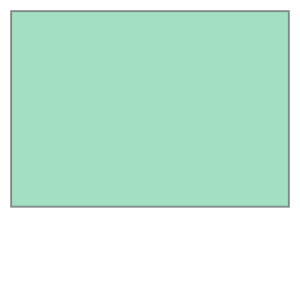

In [17]:
bbox = box(sb_mainland_bounds.minx,
           sb_mainland_bounds.miny,
           sb_mainland_bounds.maxx,
           sb_mainland_bounds.maxy)
bbox

In [20]:
bbox_df = gpd.GeoDataFrame({'geometry':bbox}, index=[0], crs = sb.crs)
bbox_df

,geometry
0,"POLYGON ((827087.109 3809115.024, 827087.109 3..."


In [ ]:
sb_canopy = ca_canopy.rio.clip([sb_mainland.envelope], sb.crs)

In [21]:
import json
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]


In [22]:
coords = getFeatures(bbox_df)
coords

[{'type': 'Polygon',
  'coordinates': [[[827087.108958743, 3809115.024363572],
    [827087.108958743, 3889656.2901281836],
    [712735.1549834597, 3889656.2901281836],
    [712735.1549834597, 3809115.024363572],
    [827087.108958743, 3809115.024363572]]]}]

In [25]:
from rasterio.mask import mask

In [26]:
out_img, out_transform = mask(dataset=ca_canopy, shapes=coords, crop=True)

In [28]:
out_img

array([[[-9999, -9999, -9999, ...,     0,     0,     0],
        [-9999, -9999, -9999, ...,     0,     0,     0],
        [-9999, -9999, -9999, ...,     0,     0,     0],
        ...,
        [-9999, -9999, -9999, ...,     3,     2,     2],
        [-9999, -9999, -9999, ...,     4,     2,     1],
        [-9999, -9999, -9999, ..., -9999, -9999, -9999]]], dtype=int16)

In [30]:
out_img = out_img.squeeze()
out_img.shape

(8055, 11436)

In [2]:
fp = os.getcwd()+'/SantaBarbaraCounty_lidar_2018.tif'

In [33]:
with rasterio.open(
        fp,  # file path
        'w',           # w = write
        driver='GTiff', # format
        height = out_img.shape[0], 
        width = out_img.shape[1],
        count = 1,  # number of raster bands in the dataset
        dtype = 'int16',
        crs = sb.crs,
        transform = out_transform,
) as dst:
    dst.write(out_img, 1)

In [3]:
from rasterio.plot import show

clipped = rasterio.open(fp)

#show((clipped, 1), cmap='terrain')

In [10]:
clip = clipped.read([1]).squeeze()

In [8]:
import matplotlib.pyplot as plt

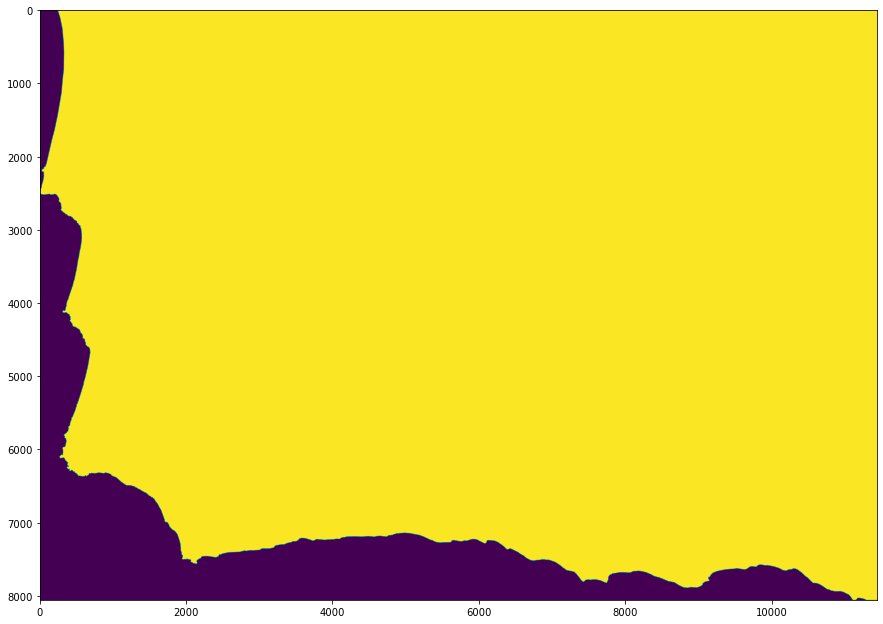

In [11]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(clip)
plt.show()